## RUL prediction using random forest

In this notebook, we will apply random forest to predict RUL of NASA's turbofan engine dataset FD001. We will use scikit-learn to implement random forest.

In [99]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 70em; }</style>"))

np.random.seed(44)

In [2]:
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Numpy version:  1.21.5
Pandas version:  1.4.2
Scikit-learn version:  1.0.2


Loading Data

In [31]:
dataset_path = "C:\\Users\\d616780\\DQuan\\2022\\12-Projet_fil_rouge\\CMAPPS_data"

In [65]:
train_data = pd.read_csv(dataset_path + "\\train_FD001.txt", sep= "\s+", header = None)
test_data = pd.read_csv(dataset_path + "\\test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv(dataset_path + "\\RUL_FD001.txt", sep = '\s+', header = None)

As analyzed in the ```Data_description_and_preprocessing.ipynb```, we need to choose a degradation model of engines so that we can derive the corresponding RULs. 

In this notebook, we work with piecewise linear degradation model. We load the pre-defined corresponding RUL to used as the outputs of training sets:

In [148]:
rul_train = pd.read_csv(dataset_path + "\\RUL_train\\RUL_train_FD001_early=125.csv")

In [149]:
rul_train

,engines,RUL
0,1.0,125.0
1,1.0,125.0
2,1.0,125.0
3,1.0,125.0
4,1.0,125.0
...,...,...
20626,100.0,4.0
20627,100.0,3.0
20628,100.0,2.0
20629,100.0,1.0


Before actually training an algorithm, we often need to ask ourself the following (non-exhauted) list of questions:

- Should data be scaled?
- If data are scaled, should a single scaling be applied to all engines or individual scaling be applied for every engine?
- Should we split the training data into training set and validation set
- Given an algorithm, how should we test its performance? Which samples from the test set to be used?

- **Shall we use window of data to feed into the traning algorithm? If yes, which window lengths and how do they overlap?**


In this notebook, we start with a simple method (random forest) and with simple scenarios, therefore, we first test directly with the non-scaled data. We will train the algorithm on the whole training set (i.e., no spliting into traning and validation sets). Concerning the windows of data approach:

- We will first work with window_length =1 

**Main Homework: try to split data in to windows (with length different than 1) and feed it to random forest to see if one can improve the performance.**

# 1. Random Forest

## 1.1. Feeding each sample row as a data point

In [204]:
'''
Building the traning data
'''
columns_to_be_dropped = [4, 5, 9, 10, 14, 20, 22, 23]
num_engines = np.min([len(train_data[0].unique()), len(test_data[0].unique())])
x_train, x_test, y_train, y_test = [],[],[],[]

for i in np.arange(1, num_engines + 1):
    # Prepare train data
    temp_x_train = train_data[train_data[0] == i].drop(columns=columns_to_be_dropped).values
    temp_y_train = rul_train[rul_train['engines']==i]['RUL']
    
    # Prepare test data
    drop_test = test_data[test_data[0] == i].drop(columns=columns_to_be_dropped).values
    temp_x_test = np.array([drop_test[-1]] )
    temp_y_test = np.array([true_rul[i-1]])
    
    x_train.append(temp_x_train)
    y_train.append(temp_y_train)
    x_test.append(temp_x_test)
    y_test.append(temp_y_test)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

print('x_train shape= ',  x_train.shape, '; y_train shape= ',  y_train.shape, 'x_test shape= ', 
      x_test.shape, '; y_test shape= ',  y_test.shape)

x_train shape=  (20631, 18) ; y_train shape=  (20631,) x_test shape=  (100, 18) ; y_test shape=  (100,)


We now build the random forest regression model (using scikit learn package).

The parameters of this model can be found here:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [210]:
num_test_windows_list =1

rf_model = RandomForestRegressor(n_estimators= 300, # Number of decision trees
                                 max_features = "sqrt",  # to determine the number of features to consider when looking for the best spli
                                 n_jobs = -1,  # using all processors to run in parallel 
                                 random_state = 38 #Controls the randomness of bootstrapping and building trees
                                )
rf_model.fit(x_train, y_train)      # Training the model
rul_pred = rf_model.predict(x_test) # Obtain the prediction of the model w.r.t the test points

In [215]:
'''
Metric: Compute RMSE:
'''
RMSE = np.sqrt(mean_squared_error(true_rul, rul_pred))
print("RMSE: ", RMSE)

RMSE:  18.90504546410825


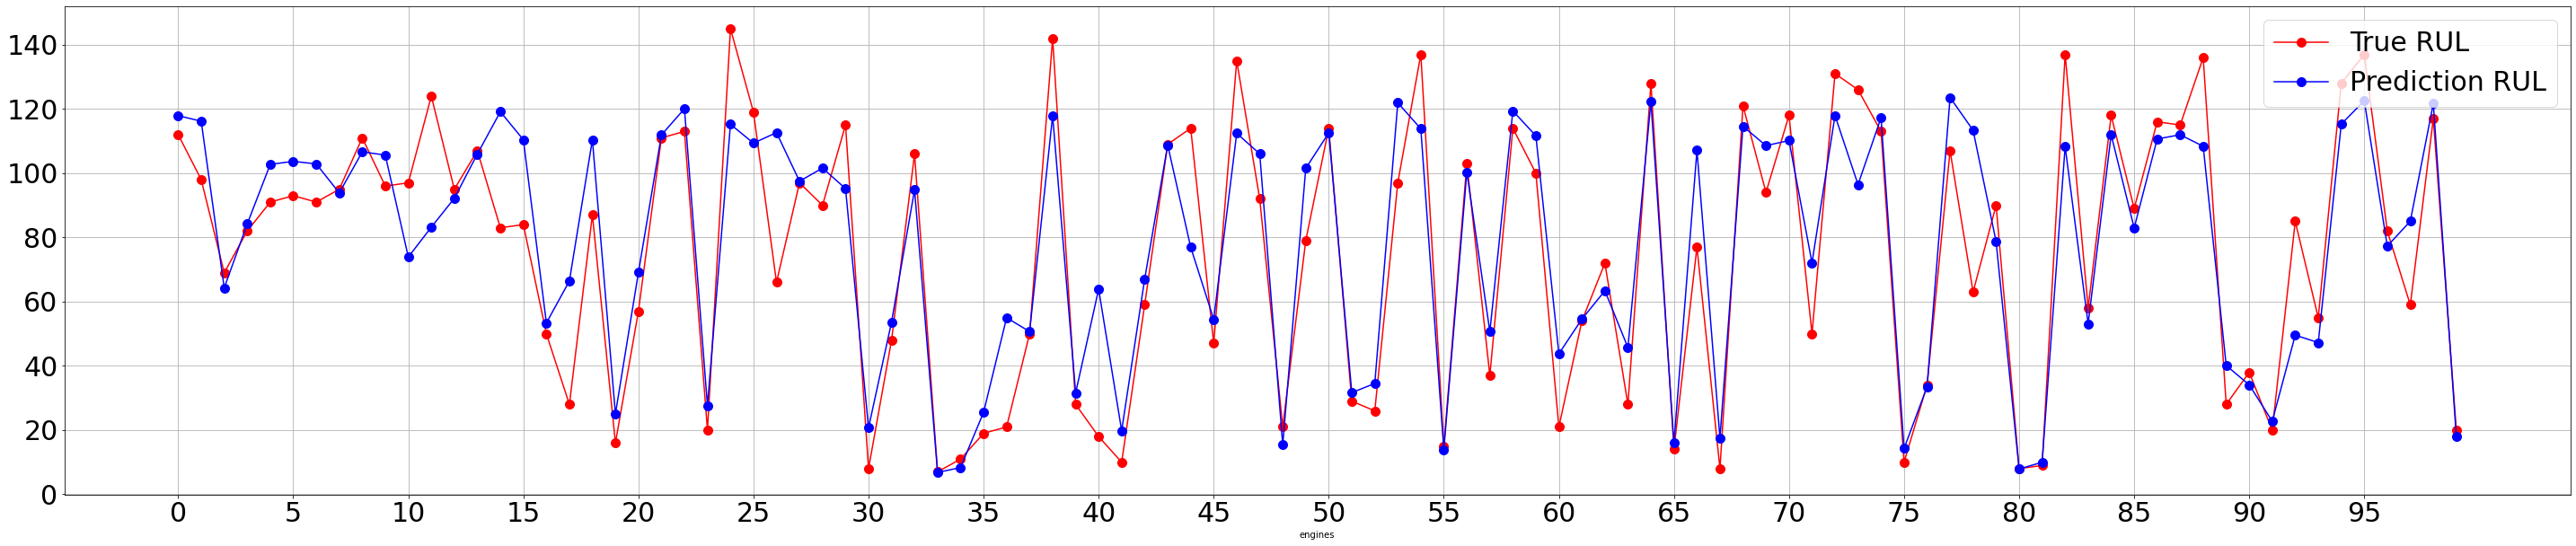

In [216]:
# Plot true and predicted RUL values
fig, ax = plt.subplots(figsize=(50,10))
ax.plot(true_rul, label = "True RUL", color = "red",marker = 'o',markersize = 10)
ax.plot(mean_pred_for_each_engine, label = "Prediction RUL", color = "blue",marker = 'o',markersize = 10)
ax.legend(loc=1,fontsize=30)
ax.grid()
ax.set_xlabel('engines')
ax.set_xticks(np.arange(0, len(true_rul), step=5))
ax.tick_params(axis='both', which='major', labelsize=30)

plt.show()


For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where, 

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [217]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [218]:
s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

S-score:  746.0729785406406


## Homework: Tuning hyperparameters of the random forest

With somewhat arbitrary choice of hyperparameters, we obtained an RMSE value of 19.17. But can we do better? To find out better values of hyperparameters, we can do a principled hyperparameter tuning. There are different ways to do hyperparameter search. Here, we will use simple grid search. 

In grid search, we first define a grid of parameters. Then for each set of parameters, we will fit a 2 xgboost models (as it is 2 fold cross validation). Finally we will average the result of all folds for a particular parameter choice. The parameter choice that gives best score for cross validation is chosen as the best hyperparameter.

Grid search of hyperparameters (with cross validation) is computationally intensive. It might take a long time on a personal computer. If that is the case, readers are advised to comment the next cell and directly use the best hyperparameter values as done in subsequent cells.

In [219]:
param_grid = {"n_estimators": [100, 300, 500],  
              "max_features": ["sqrt"]} 
grid = GridSearchCV(RandomForestRegressor(), param_grid = param_grid,scoring = "neg_root_mean_squared_error",
                    n_jobs = -1, cv = 2)
grid.fit(x_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': ['sqrt'],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_root_mean_squared_error')

We will use the best model to predict on test set.

In [222]:
best_rf_model = grid.best_estimator_
rul_pred_tuned = best_rf_model.predict(x_test)

RMSE_tuned = np.sqrt(mean_squared_error(true_rul, rul_pred_tuned))
print("RMSE after hyperparameter tuning: ", RMSE_tuned)

RMSE after hyperparameter tuning:  18.70500773589789


**Remark:** In the cells above, we fed directly the training data into RF which implicitly retain the structure of the data set (192 rows of data for engine 1 first, then 287 rows of engine 2 second, and so on). Possible  homework: try to re-do the above experiments but with shuffled data: One can do the following:

```index = np.random.permutation(len(y_train))```

```x_train, y_train = x_train[index], y_train[index]```

## 1.2. Changing the learning window

We can split the data into windows and feed them to the algorithm. Note that, by doing this, when evaluate the performance of the algorithm, we can either:
- test with the last point in the test dataset
- test with a window of the test dataset with the same length
 

**HomeWork**

Prepare the data with window_length = k and shift = 1.

In this case, for the x_train, we have a certain number of batches, each batch contains k rows. The two consecutive batches with have k-1 overlapping rows (because we set shift =1). For y_train, for each batch, we should use the RUL corresponding to the last row in the batch. Similarly, for the y_train and y_test.

At the end, one would expect to have:
- x_train shape:  (20231, k, 18) , i.e., 20231 batches, each batch is a matrix of k * 18 (i.e., a batch has k row, each row has 18 columns/ features)

- y_train shape: (20231,)

- x_test shape:  (k * 100, k, 18)

- y_test shape: (100,)


**Note 1**: Theoretically, to have a better evaluation, we should test with several batches of the test set and take the average performance. Beware that the \\RUL_FD001.txt file only contains the y_values of the last row of each engines. If one want to test with an arbitrary batch in the test set, one need to re-compute the corresponding RUL.)



**Remark:** if one change shift to something other than 1, the number of batches (i.e., the first number in the tuples representing the shapes above) can be computed as:

num_batches_input = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
num_batches_output = np.int(np.floor((len(ouput_data) - window_length)/shift)) + 1

